# **OutlierLab – Toolkit für robuste Ausreißeranalyse, Bereinigung & Visualisierung**

## Importieren den Grundlegende Paket & Projektvercheinis

In [1]:
# Notebook: notebooks/load_dat.ipynb

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# ✅ Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide


In [2]:
# Verify that core is importable
try:
    import core

    print("✅ core module found at:", core.__file__)
except ModuleNotFoundError:
    print("❌ core module not found. Check your sys.path!")

:weißes_häkchen: Connected to PostgreSQL database.
✅ core module found at: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/__init__.py


In [ ]:
eda_data_path = os.path.join(project_root, "data", "processed")
eda_figures_path = os.path.join(project_root, "reports", "eda", "viz")
outlier_figures_path = os.path.join(eda_figures_path, "outliers")
os.makedirs(eda_data_path, exist_ok=True)
os.makedirs(eda_figures_path, exist_ok=True)
os.makedirs(outlier_figures_path, exist_ok=True)

## **Import Core Function**

In [4]:
#  Import functions from core
# ============================================================
from core import (
    load_table,
    load_custom_query,
)  # Beispiel Funktion zum Laden von Tabellen

# **Die Ausreise- Bereinigung**

Im Abschnitt **`load_data.ipynb`** haben wir die Verteilung zentraler Variablen untersucht und dabei mehrere auffällige Ausreißer identifiziert, die für die Datenbereinigung und Modellqualität besonders relevant sind:
- **`session_duration`**: Die durchschnittliche Sitzungsdauer beträgt 87 Minuten, mit einem Median von 60 Minuten. Das Maximum liegt jedoch bei 7.200 Minuten (5 Tage), was auf technische Fehler oder ungewöhnlich lange Inaktivität hindeuten könnte.
- **`page_clicks`**: Mit einem Mittelwert von 17,6 und einem Maximum von 566 Klicks zeigt sich eine extreme Streuung. Der Median liegt bei 13, was den Ausreißerwert als deutlich überhöht bestätigt und auf eine ungewöhnlich intensive Nutzung einzelner Sitzungen hindeutet.
- **`nights`**: Die durchschnittliche Aufenthaltsdauer beträgt 3,67 Nächte, jedoch wurden auch negative Werte bis -2 registriert. Diese sind logisch nicht interpretierbar und weisen auf fehlerhafte oder unplausible Einträge hin.
- **`base_fare_usd`**: Der durchschnittliche Flugpreis liegt bei 525,90 USD, während der Median bei 381,77 USD liegt. Das Maximum von über 21.500 USD deutet auf einzelne Luxus- oder fehlerhafte Buchungen hin, die die Verteilung stark verzerren können.
Diese Ausreißer beeinflussen statistische Kennzahlen wie Mittelwert und Standardabweichung erheblich und können zu verzerrten Modellprognosen führen. Eine gezielte Behandlung – etwa durch Entfernung, Transformation oder robuste Modellierung – ist daher essenziell für valide Analysen und zuverlässige Ergebnisse.

## sessions base laden

In [5]:
base_sessions = load_table(data_type="sql", table_name="session_base")

:blatt_oben: Lade Tabelle 'session_base' aus SQL-Datei: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/../sql/session_base.sql
:blatt_oben: Executing SQL from file: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/../sql/session_base.sql
:weißes_häkchen: Query executed. 49211 rows retrieved.
:weißes_häkchen: SQL-Abfrage erfolgreich. Zeilen: 49211
:diskette: Gespeichert unter: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/core/../data/processed/session_base.csv


## Datum und Zeit- Spalten formatieren

In [6]:
# Date Prüfung
# Liste der Datums-/Zeitspalten in base_sessions
date_columns = [
    "birthdate",  # User
    "sign_up_date",  # User
    "session_start",  # Session
    "session_end",  # Session
    "departure_time",  # Flight
    "return_time",  # Flight
    "check_in_time",  # Hotel
    "check_out_time",  # Hotel
]

# Datums-/Zeitspalten in datetime konvertieren
for col in date_columns:
    if col in base_sessions.columns:
        base_sessions[col] = pd.to_datetime(base_sessions[col], errors="coerce")

# Optional: Überprüfen, ob Konvertierung erfolgreich war
print("✅ Datums-/Zeitspalten nach der Konvertierung:")
print(base_sessions[date_columns].dtypes)

✅ Datums-/Zeitspalten nach der Konvertierung:
birthdate         datetime64[ns]
sign_up_date      datetime64[ns]
session_start     datetime64[ns]
session_end       datetime64[ns]
departure_time    datetime64[ns]
return_time       datetime64[ns]
check_in_time     datetime64[ns]
check_out_time    datetime64[ns]
dtype: object


## Berechnungen der Sitzungsdauer (Sessions- Duration)

In [7]:
# Berechnung der Sitzungsdauer in Sekunden
base_sessions["session_duration"] = (
    base_sessions["session_end"] - base_sessions["session_start"]
).dt.total_seconds()

## Diskripteve Statistik Zentraler Verhaltensmerkmale

In [8]:
# Deskriptive Statistik für ausgewählte numerische Spalten...
columns_to_describe = ["session_duration", "page_clicks", "nights", "base_fare_usd"]

# Deskriptive Statistik berechnen...
summary_stats = base_sessions[columns_to_describe].describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
session_duration,49211.0,187.252329,660.250156,6.00,45.0000,96.000,162.0000,7200.00
page_clicks,49211.0,17.588791,21.495987,1.00,6.0000,13.000,22.0000,566.00
nights,14726.0,3.672484,3.806717,-2.00,1.0000,2.000,5.0000,43.00
base_fare_usd,14270.0,525.901390,818.296468,2.41,200.4325,381.765,600.6325,21548.04


In [ ]:
from scipy import stats  # Importiert statistische Funktionen für Z-Score Berechnung
import numpy as np  # Importiert numpy für mathematische Operationen
import pandas as pd  # Importiert pandas für DataFrame-Manipulation


def handle_outliers(
    df,  # Der DataFrame mit den zu bereinigenden Daten
    column,  # Der Name der Spalte in der Ausreißer behandelt werden sollen
    method="iqr",  # Methode zur Ausreißererkennung: "iqr" oder "zscore"
    action="remove",  # Aktion für Ausreißer: "remove", "clip" oder "transform"
    clip_value=None,  # Optional: Manuelle Grenzwerte für Clipping als (min, max)
    z_thresh=3,  # Schwellenwert für Z-Score Methode (Standard: 3 Standardabweichungen)
):
    """
    Hauptfunktion zur Erkennung und Behandlung von Ausreißern in einer DataFrame-Spalte
    """

    # SCHRITT 1: Erstelle eine Kopie des DataFrames um Originaldaten nicht zu verändern
    df = df.copy()

    # SCHRITT 2: AUSREIßER ERKENNUNG - Je nach gewählter Methode
    if method == "iqr":
        # IQR-Methode: Basierend auf Quartilen und Interquartilsabstand

        # Berechne das untere Quartil (25%-Perzentil) - 25% der Daten liegen darunter
        Q1 = df[column].quantile(0.25)

        # Berechne das obere Quartil (75%-Perzentil) - 75% der Daten liegen darunter
        Q3 = df[column].quantile(0.75)

        # Berechne den Interquartilsabstand - Bereich der mittleren 50% der Daten
        IQR = Q3 - Q1

        # Berechne untere Grenze: Werte darunter gelten als Ausreißer
        lower_bound = Q1 - z_thresh * IQR

        # Berechne obere Grenze: Werte darüber gelten als Ausreißer
        upper_bound = Q3 + z_thresh * IQR

        # Erstelle eine Maske: True für normale Werte, False für Ausreißer
        mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)

    elif method == "zscore":
        # Z-Score Methode: Basierend auf Standardabweichungen vom Mittelwert

        # Berechne Z-Scores: Wie viele Standardabweichungen jeder Wert vom Mittelwert entfernt ist
        # np.abs() für absolute Werte, dropna() ignoriert fehlende Werte
        z_scores = np.abs(stats.zscore(df[column].dropna()))

        # Erstelle Maske: True für Werte innerhalb des Schwellenwerts
        mask = z_scores < z_thresh

        # Konvertiere Maske zurück zum originalen DataFrame-Index
        # Zuerst erstellen wir eine Series mit den originalen Indizes
        mask = pd.Series(mask, index=df[column].dropna().index)
        # Dann erstellen wir eine Maske die zum gesamten DataFrame passt
        mask = df.index.isin(mask[mask].index)

    else:
        # Fehlerbehandlung falls unbekannte Methode gewählt wurde
        raise ValueError("Method must be 'iqr' or 'zscore'")

    # SCHRITT 3: AUSREIßER BEHANDLUNG - Je nach gewählter Aktion
    if action == "remove":
        # Aktion: Ausreißer entfernen - Behalte nur Zeilen mit normalen Werten
        df_cleaned = df[mask]  # Filtere DataFrame mit der Maske

    elif action == "clip":
        # Aktion: Ausreißer begrenzen - Setze extreme Werte auf Grenzwerte

        # Wenn keine manuellen Clip-Werte angegeben, berechne automatisch
        if clip_value is None:
            # Verwende IQR-Methode um automatisch Grenzen zu berechnen
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - z_thresh * IQR
            upper_bound = Q3 + z_thresh * IQR
            clip_value = (lower_bound, upper_bound)  # Setze automatische Grenzen

        # Begrenze alle Werte in der Spalte auf die berechneten Grenzen
        # Werte unter clip_value[0] werden auf clip_value[0] gesetzt
        # Werte über clip_value[1] werden auf clip_value[1] gesetzt
        df[column] = df[column].clip(lower=clip_value[0], upper=clip_value[1])
        df_cleaned = df  # Verwende den modifizierten DataFrame

    elif action == "transform":
        # Aktion: Logarithmische Transformation - Reduziert extreme Werte mathematisch
        # np.log1p() berechnet log(1 + x) - stabiler als log(x) für Werte nahe 0
        df[column] = np.log1p(df[column])
        df_cleaned = df  # Verwende den transformierten DataFrame

    else:
        # Fehlerbehandlung falls unbekannte Aktion gewählt wurde
        raise ValueError("Action must be 'remove', 'clip', or 'transform'")

    # SCHRITT 4: Gib den bereinigten DataFrame zurück
    return df_cleaned

In [ ]:
def plot_outlier_comparison(
    df,
    column,
    method="iqr",
    action="clip",
    clip_value=None,
    z_thresh=3,
    figsize=(12, 10),
):
    """
    Plots a 4-panel comparison: boxplot and KDE histogram for original and cleaned data.
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column name to analyze.
    - method (str): Outlier detection method ('iqr' or 'zscore').
    - action (str): Outlier handling action ('remove', 'clip', or 'transform').
    - clip_value (tuple): Custom (lower, upper) bounds for clipping.
    - z_thresh (float): Threshold multiplier for outlier detection.
    - figsize (tuple): Size of the plot figure.
    Returns:
    - pd.DataFrame: The DataFrame after the specified cleaning action.
    """
    df_cleaned = df.copy()  # Must copy to ensure original df is unchanged
    # 1. Determine df_cleaned based on the column name
    if column == "nights":
        # SPECIAL CASE: Only apply non-zero correction; skip handle_outliers logic
        # Replace non-positive values (<= 0) with 1
        if (df_cleaned[column] <= 0).any():
            df_cleaned[column] = df_cleaned[column].apply(lambda x: 1 if x <= 0 else x)
    else:
        # STANDARD CASE: Use the handle_outliers function
        df_cleaned = handle_outliers(
            df,
            column,
            method=method,
            action=action,
            clip_value=clip_value,
            z_thresh=z_thresh,
        )
    # 2. Create the 2x2 Plot Structure
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    plt.suptitle(
        f"Outlier Comparison for: {column} (Method: {method.upper()}, Action: {action.upper()})",
        fontsize=16,
    )

    # Top Left: Boxplot Original
    sns.boxplot(x=df[column], ax=axes[0, 0], color="lightcoral")
    axes[0, 0].set_title(f"{column} Boxplot (Original)")
    axes[0, 0].set_xlabel(column)

    # Top Right: KDE Histogram Original
    sns.histplot(df[column].dropna(), kde=True, ax=axes[0, 1], color="darkred")
    axes[0, 1].set_title(f"{column} Histogram + KDE (Original)")
    axes[0, 1].set_xlabel(column)

    # Bottom Left: Boxplot Cleaned
    sns.boxplot(x=df_cleaned[column], ax=axes[1, 0], color="lightgreen")
    axes[1, 0].set_title(f"{column} Boxplot (Cleaned)")
    axes[1, 0].set_xlabel(column)

    # Bottom Right: KDE Histogram Cleaned
    sns.histplot(
        df_cleaned[column].dropna(), kde=True, ax=axes[1, 1], color="darkgreen"
    )
    axes[1, 1].set_title(f"{column} Histogram + KDE (Cleaned)")
    axes[1, 1].set_xlabel(column)

    # 3. Final Layout and Display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    rel_path = os.path.join(
        outlier_figures_path, f"{column}_outlier_comparison_4panel.png"
    )
    plt.savefig(rel_path, dpi=300)
    plt.show()

    # 4. Return the cleaned DataFrame
    return df_cleaned

### base_far_usd bereinigt mit iqr und clip method

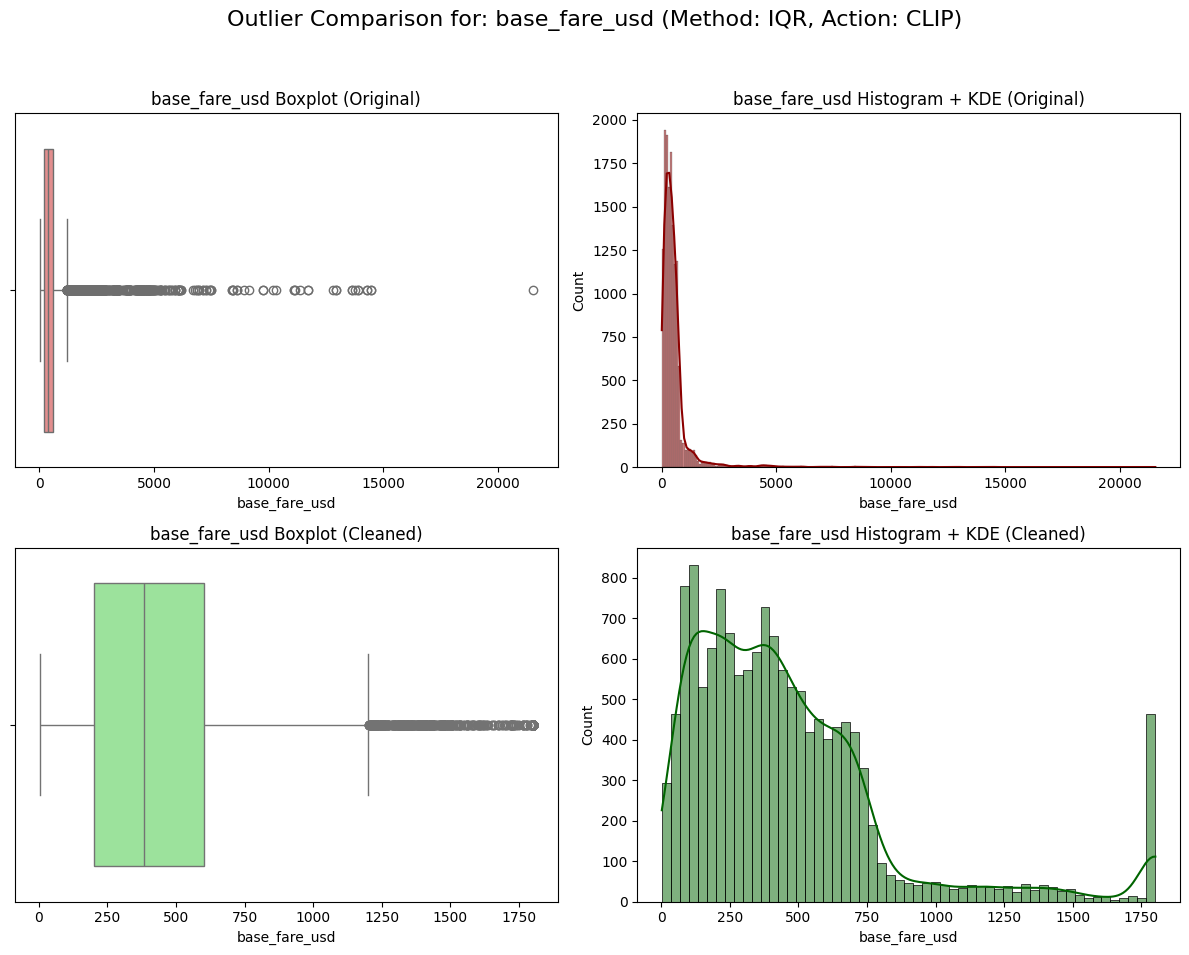

In [11]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column="base_fare_usd",
    method="iqr",
    action="clip",
)

### Page- Klicks 

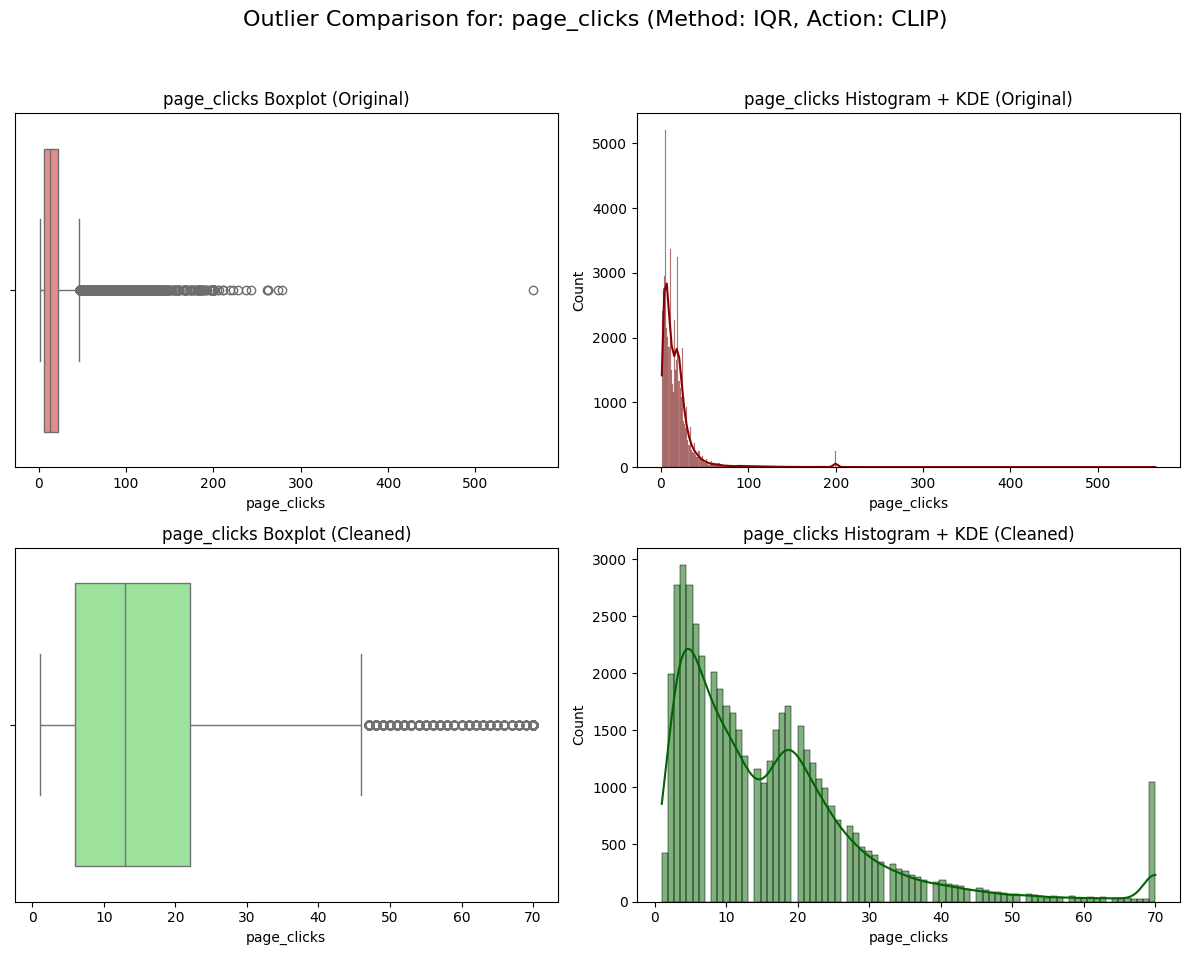

In [12]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column="page_clicks",
    method="iqr",
    action="clip",
)

### Session- duration 

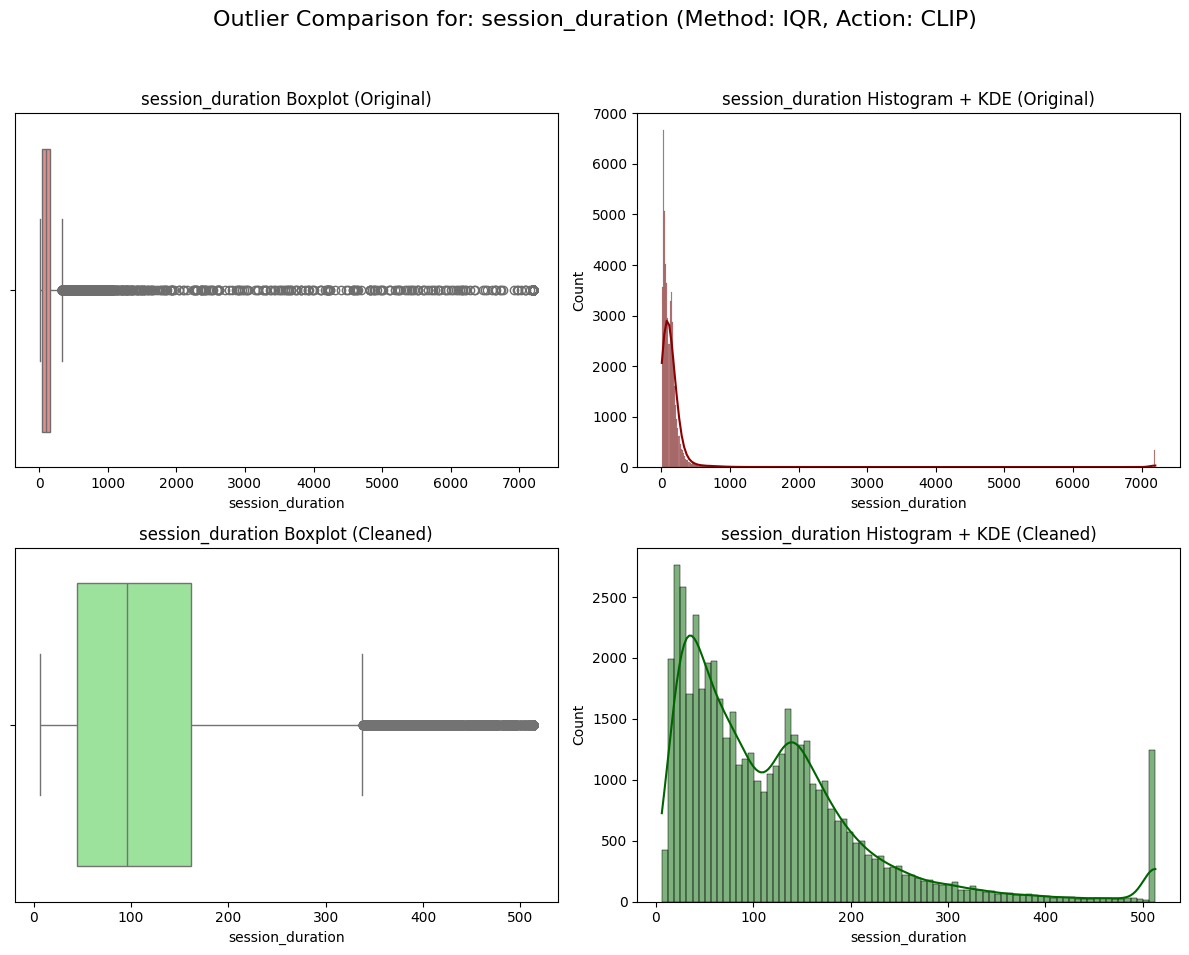

In [ ]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions, column="session_duration", method="iqr", action="clip"
)

### Nights 

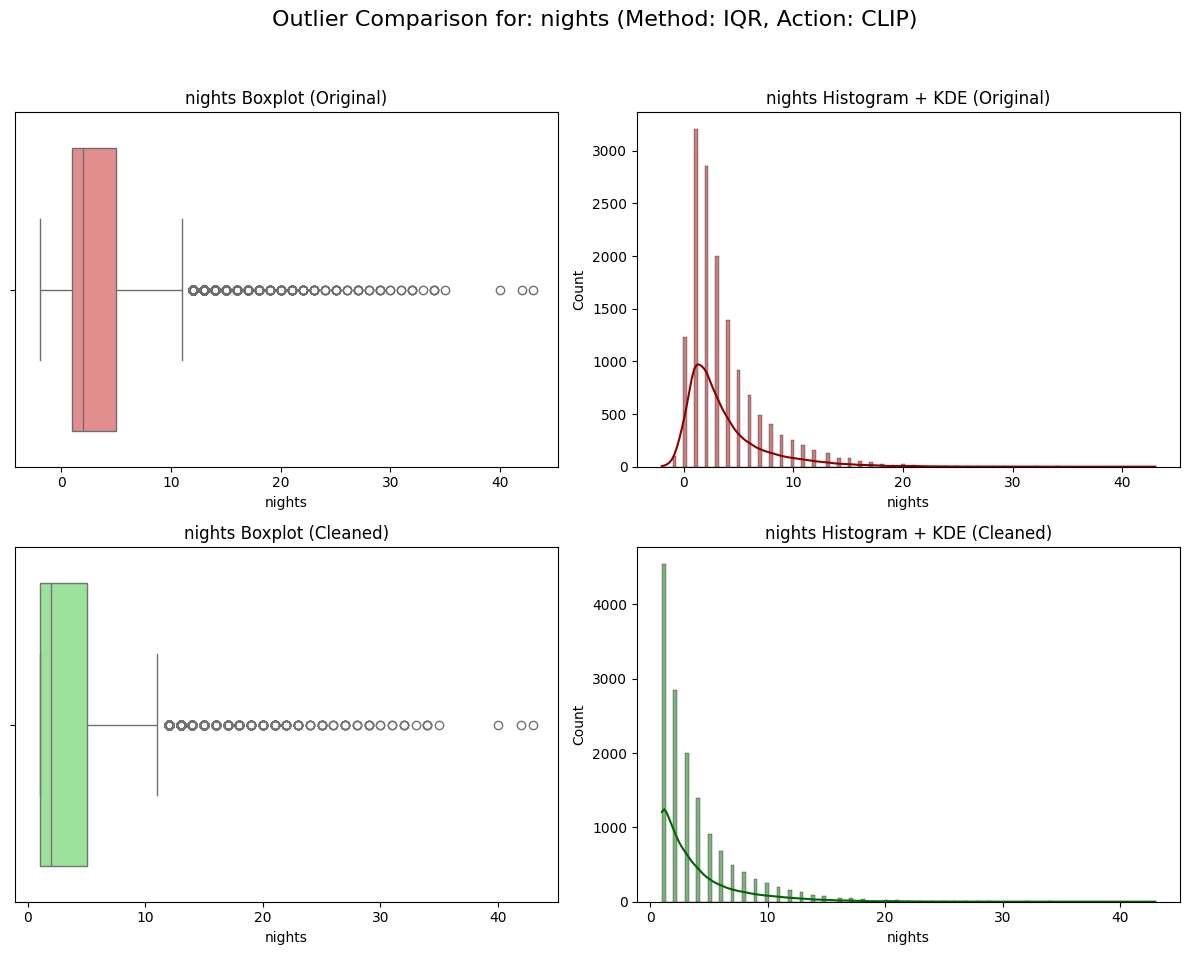

In [ ]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column="nights",
)

# **Bereinigte Daten Speicherung**

In [15]:
# **Data Speicherung**
save_path = os.path.join(eda_data_path, "sessions_cleaned.csv")

# Speichern als CSV
df_cleaned.to_csv(save_path, index=False)
print(f"Cleaned sessions saved to: {save_path}")

Cleaned sessions saved to: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/data/processed/sessions_cleaned.csv


## detected cancel trip

In [16]:
query = """
SELECT
DISTINCT trip_id
FROM sessions 
WHERE cancellation = TRUE;
"""

## cancel- trip

In [17]:
cancel_trips_ids_df = load_custom_query(query)

:gehirn: Führe benutzerdefinierte SQL-Abfrage aus...
:weißes_häkchen: Query executed. 90670 rows retrieved.


,trip_id
4394,119133-213c491e63a046faa0f92147307558a3
28378,234912-a49005f2c2ca4563ba3b24bd84541f77
86933,89490-4e6cd298ce834dd895411310fc365859
68778,62693-6e86468f3b9e4de4bb0e5e8ada5614bf
17515,181011-c2c1731e95b94c0ca13d5967c70615d5
...,...
33099,25963-1974873592524511b343078656dd500a
929,103743-06c87d6b9aa24155a098905ad9432e84
31979,253484-847e982b90ac4f329d008944c5306230
30807,247568-a83749f005a44e65bf00e1b6034dae2a


In [ ]:
#  Anzahl stornierter Reisen anzeigen

print(
    ":raute_blau_klein: Gesamtzahl stornierter Reisen (~5 Mio Sessions):",
    cancel_trips_ids_df.shape[0],
)

#  Sessions bereinigen: Nur gültige trip_id behalten

df_not_canceled_trips = df_cleaned.dropna(
    subset=["trip_id"]
)  # Entferne Zeilen ohne trip_id
df_not_canceled_trips = df_not_canceled_trips[
    ~df_not_canceled_trips["trip_id"].isin(cancel_trips_ids_df)
]  # Entferne stornierte Reisen
#  Überblick über Filterung
print(" Ursprüngliche Sessions (nach Clipping und Tranform):", df_cleaned.shape)
print(":weißes_häkchen: Nicht stornierte Reisen:", df_not_canceled_trips.shape)
df_not_canceled_trips = df_not_canceled_trips.drop_duplicates(subset=["trip_id"])
#  Bereinigte Daten speichern
filtered_save_path = os.path.join(eda_data_path, "sessions_not_canceled_trips.csv")
df_not_canceled_trips.to_csv(filtered_save_path, index=False)
print(f":diskette: Bereinigte Sessions gespeichert unter: {filtered_save_path}")

:raute_blau_klein: Gesamtzahl stornierter Reisen (~5 Mio Sessions): 90670
 Ursprüngliche Sessions (nach Clipping und Tranform): (49211, 42)
:weißes_häkchen: Nicht stornierte Reisen: (16702, 42)
:diskette: Bereinigte Sessions gespeichert unter: /Users/sadiqqais/Masterschool/Projekt/Mastery_projekt/Travel_tide/data/processed/sessions_not_canceled_trips.csv
